# Análise de Crédito com Redes Neurais
#### Tutorial por: Victor Dahan
- Linkedin: https://www.linkedin.com/in/victordhn/

**Objetivo:** Este tutorial tem como objetivo demonstrar a aplicação de redes neurais na previsão de riscos de crédito. A ideia é não só alcançar uma alta precisão no modelo, mas também garantir que ele generalize bem para diferentes conjuntos de dados de operações de crédito.

**Modelo Utilizado:** O modelo utilizado é o de Redes Neurais, implementado com TensorFlow/Keras, para prever casos de alto risco de crédito. Redes neurais são técnicas de previsão modernas que normalmente brilham quando temos muitos dados para processar. Mesmo com um conjunto de dados mais limitado, elas podem ser tão eficazes quanto métodos clássicos de classificação, como regressão logística ou SVM.

___

#### 1. Breve Introdução sobre Redes Neurais
- O modelo de redes neurais tenta simular o funcionamento do cérebro humano através de camadas de neurônios artificiais que processam e transmitem a informação da fonte até a saída. O mecanismo básico é que em cada camada são aplicados pesos e viéses para o modelo preditivo, e através do mecanismo de feed-forward a informação é transmitida adiante, enquanto o mecanismo de backpropagation realiza um ajuste nestes pesos e viéses de acordo com o resultado obtido na camada final, de trás para frente.
- O modelo realiza esse looping de feed-forward e backpropagation por um número determinado de vezes, ou até que alguma medida de precisão seja atingida.
- Alguns dos parâmetros que definimos no modelo são o número de camadas, o número de neurons por camada, o algorítimo de otimização e a função de perda

- 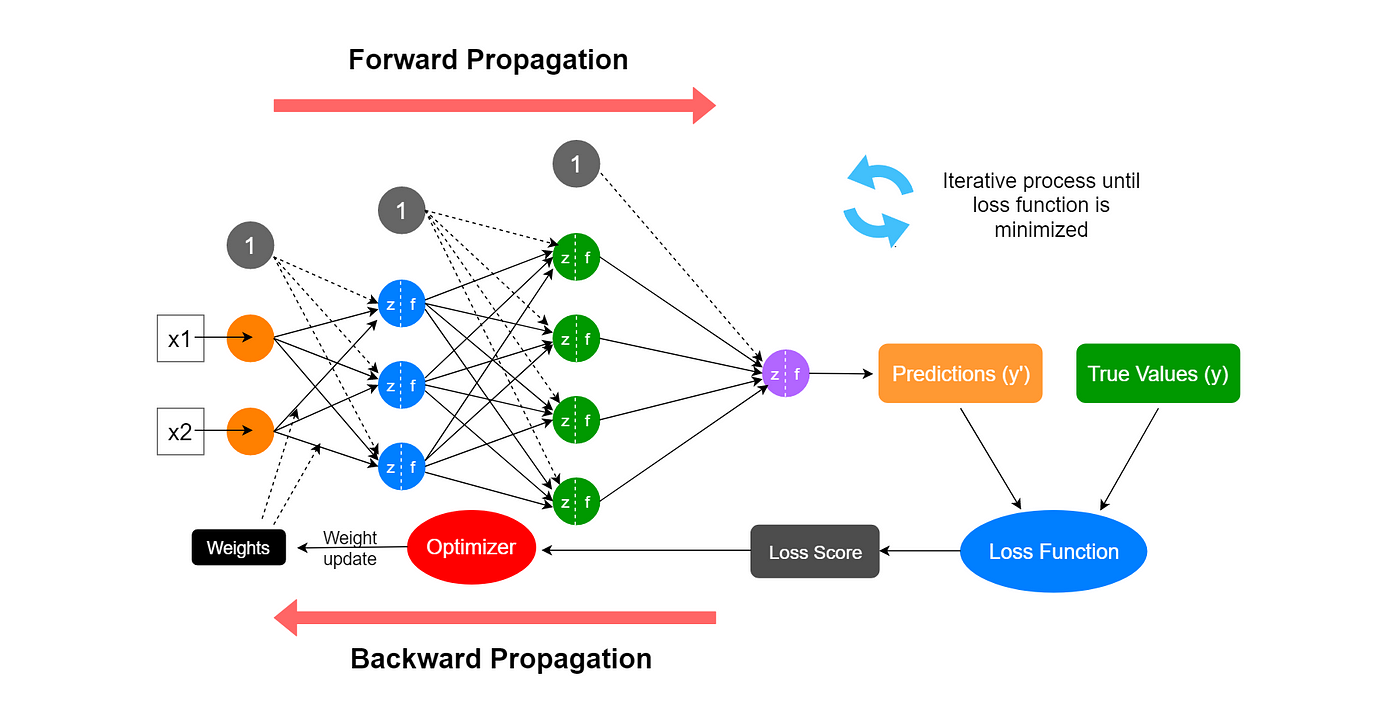

___
#### 2. Dataset 
- O dataset utilizado é um clássico no Kaggle: german_data_credito (fonte: https://www.kaggle.com/datasets/uciml/german-credit)
- As variáveis do modelo são: idade, sexo, cargo, moradia, conta poupança, conta corrente, tamanho do crédito, maturidade, motivação.
- A variável que queremos prevemos é o risco de crédito e está codificada como Bad_Risk: 1 = alto risco; 0 = baixo risco.

Importante:
- **Neste tutorial os dados já estão limpos e pré-processados** (tenho tutorial completo da limpeza dos dados neste notebook - https://github.com/victordhn/Finance-Projects/blob/master/Credit%20Analysis/An%C3%A1lise%20de%20Cr%C3%A9dito%20SVM.ipynb)
- O dataset limpo está postado no Github e no Kaggle (credit_data_clean.csv)

In [4]:
import pandas as pd
df_clean = pd.read_csv('./credit_data_clean.csv')

In [5]:
df_clean

,Age,Credit amount,Duration,Sex_female,Sex_male,Housing_free,Housing_own,Housing_rent,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Savings_Acc,Checking_Acc,Job_Skill,Bad_Risk
0,-1.094447,0.913171,2.139356,True,False,False,True,False,False,False,False,False,False,True,False,False,0,1,2,1
1,0.858575,1.573037,1.657897,False,True,True,False,False,False,False,False,False,True,False,False,False,0,0,2,0
2,1.537887,0.543768,0.213521,False,True,True,False,False,False,True,False,False,False,False,False,False,0,0,2,1
3,0.009435,1.253868,1.176438,False,True,False,False,True,False,True,False,False,False,False,False,False,0,1,3,0
4,-0.584963,0.668155,0.694979,False,True,False,True,False,False,True,False,False,False,False,False,False,0,1,3,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,1.113317,-0.524799,0.213521,False,True,False,True,False,False,False,False,False,False,True,False,False,0,1,1,0
518,-0.415135,0.232459,1.176438,False,True,False,True,False,False,False,False,False,True,False,False,False,0,0,3,0
519,0.434005,0.197603,0.694979,False,True,False,True,False,False,True,False,False,False,False,False,False,0,0,3,0
520,-1.009533,-0.489943,1.898626,False,True,True,False,False,False,False,False,False,False,True,False,False,0,0,2,1


___
#### 3. Definindo o modelo: Rede Neural com Tensorflow/Keras
Passo-a-passo:
- Separar o dataset em treino/teste.
- Definir o modelo sequencial utilizando:
1. uma camada de entrada com input = número de variáveis independentes
2. duas camadas ocultas densas (utilizando a função de ativação ReLU)
3. uma camada de saída (utilizando a função de ativação Sigmoid)

- Para controlar o problema de overfitting utilizarei três recursos:
1. Um regularizador L2 em todas as camadas exceto a camada de saída (aplicado na definição do modelo)
2. O mecanismo de Dropout que adiciona uma probabilidade de não ativação para cada neurônio (aplicado na definição do modelo)
3. Um mecanismo parada que interrompe o treino do modelo quando a loss_function começar a aumentar, sugerindo o início do problema de overfitting (aplicado no treino do modelo)

In [7]:
from sklearn.model_selection import train_test_split
X = df_clean.drop(columns='Bad_Risk')
y= df_clean['Bad_Risk']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [8]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((417, 19), (105, 19), (417,), (105,))

In [9]:
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [10]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping

model_2 = Sequential([
    Dense(32, activation='relu', input_shape=(X_train.shape[1],), kernel_regularizer=l2(0.002)),
    Dropout(0.2),
    Dense(16, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.2),
    Dense(8, activation='relu', kernel_regularizer=l2(0.002)),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

model_2.summary()

C:\Users\victo\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,313 (5.13 KB)

 Trainable params: 1,313 (5.13 KB)

 Non-trainable params: 0 (0.00 B)

___
#### 4. Treinando o modelo
- Otimizador utilizado: Adam ("Adaptive Moment Estimation) - permite uma taxa de aprendizado para cada parâmetro (um poouco mais flexível que o SGD)
- Função de perda: Cross-entropia Binária - ideal para previsão de variáveis binárias (0 e 1)
- Métrica utilizada: Acurácia - porcentagem de previsões corretas do modelo

In [12]:
model_2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])

- Aqui vamos treinar o modelo.
- É nesse momento que definimos o mecanismo de parada para evitar overfitting.
- Vamos setar o modelo para treinar durante 100 epochs, com amostragem de 32 observações.

Resultado:
- **Acurácia no modelo de teste: ~70%**
- **Devido a quantidade baixa de dados (apenas cerca de 500 observações), só conseguimos rodar cerca de 25 epochs até que a função de perda comece a aumentar no set de validação**.
- Mesmo com a limitação da quantidade de dados, que é um fator crucial para a qualidade de um modelo de Rede Neural, ainda obtivemos uma acurácia de cerca de 70% no dataset de treino, semelhante à acurácia obtida com o modelo de Support Vector Machine (SVM) neste tutorial: https://github.com/victordhn/Finance-Projects/blob/master/Credit%20Analysis/An%C3%A1lise%20de%20Cr%C3%A9dito%20SVM.ipynb

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
history_2 = model_2.fit(X_train, y_train, 
                        epochs=100, 
                        batch_size=32, 
                        validation_split=0.2, 
                        callbacks=[early_stopping], 
                        verbose=1)

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.5342 - loss: 0.8914 - val_accuracy: 0.5000 - val_loss: 0.8711
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5237 - loss: 0.8523 - val_accuracy: 0.5000 - val_loss: 0.8401
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5422 - loss: 0.8095 - val_accuracy: 0.5000 - val_loss: 0.8263
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5473 - loss: 0.8108 - val_accuracy: 0.4881 - val_loss: 0.8185
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5781 - loss: 0.7733 - val_accuracy: 0.5000 - val_loss: 0.8134
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5636 - loss: 0.8024 - val_accuracy: 0.4762 - val_loss: 0.8094
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5521 - loss: 0.8058 - val_accuracy: 0.4643 - val_loss: 0.8062
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5771 - loss: 0.7766 - val_accuracy: 0.4881 - 

- Vamos fazer um gráfico aqui da performance do modelo em cada epoch
- Essa é uma excelente forma de visualizar a evolução do treino do modelo
- Como utilizamos o mecanismo de early stopping, só temos 23 epochs para plotar

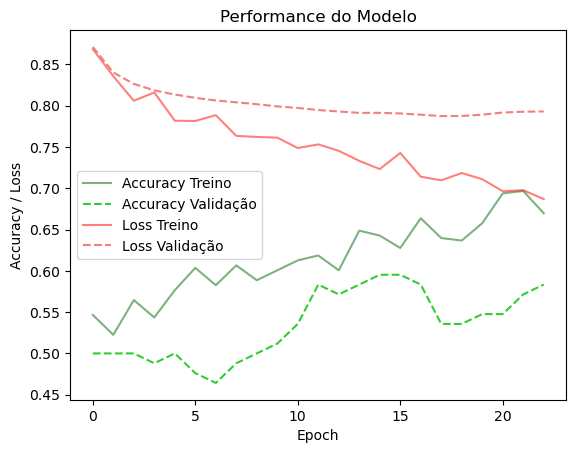

In [16]:
import matplotlib.pyplot as plt

plt.plot(history_2.history['accuracy'], label='Accuracy Treino', c='darkgreen', alpha=0.5)
plt.plot(history_2.history['val_accuracy'], label='Accuracy Validação', c='limegreen', linestyle='dashed')
plt.plot(history_2.history['loss'], label='Loss Treino', c='red',  alpha=0.5)
plt.plot(history_2.history['val_loss'], label='Loss Validação', c='lightcoral', linestyle='dashed')
plt.title('Performance do Modelo')
plt.xlabel('Epoch')
plt.ylabel('Accuracy / Loss')
plt.legend()
plt.show()

___
#### 5. Testando o modelo (test dataset)
- Vamos testar o modelo no dataset de test
- **Resultado: ~63% de acurácia**

In [18]:
test_loss, test_accuracy = model_2.evaluate(X_test, y_test)
print(f'Test_loss: {test_loss}, Test accuracy: {test_accuracy}')

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6316 - loss: 0.7480 
Test_loss: 0.7523883581161499, Test accuracy: 0.6285714507102966


- previsões and matriz de confusão

In [20]:
predictions = model_2.predict(X_test)
pred_y = (predictions > 0.5).astype(int)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


In [21]:
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(y_test, pred_y)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[44 16]
 [23 22]]


___
#### 6. Resultados
- O resultado obtido faz jus ao esperado para uma rede neural com uma baixa quantidade de observações. 63% de acurácia no modelo é razoável, e ligeiramente inferior ao obtido com métodos de classificação baseados em agrupamento de dados.
- A grande vantagem do modelo de Rede Neural neste caso é a facilidade de se generalizar para datasets com milhares e até milhões de observações.
- Outra grande lição aprendida neste estudo é que as Redes Neurais nem sempre serão o modelo mais indicado para uma tarefa de predição, o que contraria um pouco o senso comum do atual estado da ciência de dados.

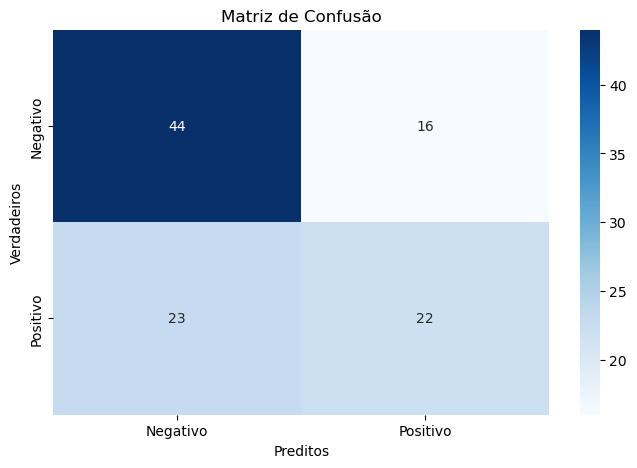

In [22]:
import seaborn as sns
df_cm = pd.DataFrame(conf_matrix, index=['Negativo', 'Positivo'], columns=['Negativo', 'Positivo'])
plt.figure(figsize=(8,5))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='Blues')
plt.title('Matriz de Confusão')
plt.ylabel('Verdadeiros')
plt.xlabel('Preditos')
plt.show()